In [16]:
# Import necessary libraries
import os
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.models import Model

%config InlineBackend.figure_format = 'svg' # Display matplotlib figures as SVG

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

ModuleNotFoundError: No module named 'sklearn'

| **Attributes**         | **Description**                                                                 |
|--------------------|----------------------------------------------------------------------------------|
| `title`            | Title of the piece. Most entries are songs, but there are also some books, poems, and other content |
| `tag`              | Genre of the piece. Most non-music pieces are labeled as "misc", but not all. Some songs are also labeled as "misc" |
| `artist`           | Person or group the piece is attributed to                                      |
| `year`             | Release year                                                                    |
| `views`            | Number of page views                                                            |
| `features`         | Other contributing artists                                                      |
| `lyrics`           | Lyrics or text content                                                          |
| `id`               | Genius identifier                                                               |
| `language_cld3`    | Lyrics language according to CLD3. Unreliable results are marked as NaN         |
| `language_ft`      | Lyrics language according to FastText's langid. Values with low confidence (<0.5) are NaN |
| `language`         | Combines `language_cld3` and `language_ft`. Only has a non-NaN entry if both agree |


# Data Cleaning & Preprocessing:

In [2]:
# Get the current working directory (where the notebook is running)
base_dir = os.getcwd()

# Build the relative path to the CSV file (e.g., "../data/song_lyrics.csv")
relative_path = os.path.normpath(os.path.join(base_dir, '..', 'data', 'song_lyrics.csv'))

# Print debug info
print("Current working directory:", base_dir)
print("Absolute file path:", os.path.abspath(relative_path))
print("Does the file exist?", os.path.exists(relative_path))

# Try to load the dataset
try:
    # Set low_memory=False to speed up parsing of large files
    dataset = pd.read_csv(relative_path, low_memory=False)
    
    print("File loaded successfully.\n")
    print("First 10 rows:")
    print(dataset.head(10))
    print("\nDataset Info:")
    print(dataset.info())
except FileNotFoundError:
    print("File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")


Current working directory: /Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/Coding
Absolute file path: /Users/lucaschambeck/Library/CloudStorage/OneDrive-ZHAW/Studium/Semester 4/PM4/PM4_Lyrics/data/song_lyrics.csv
Does the file exist? True
File loaded successfully.

First 10 rows:
               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   
5     Lollipop Remix  rap  Lil Wayne  2008  580832   
6         Im Not You  rap     Clipse  2002   28645   
7        Family Ties  rap    Cam'ron  2004   41960   
8  Rockin and Rollin  rap    Cam'ron  1998    6399   
9      Lord You Know  rap    Cam'ron  2004   11882   

                                       features  \
0                   {"Cam\\'ron

In [3]:
# Show dataset shape
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

# Show first 10 rows
print(dataset.head(10))


               title  tag     artist  year   views                                      features                                             lyrics  id language_cld3 language_ft language
0          Killa Cam  rap    Cam'ron  2004  173166                   {"Cam\\'ron","Opera Steve"}  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...   1            en          en       en
1         Can I Live  rap      JAY-Z  1996  468624                                            {}  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...   3            en          en       en
2  Forgive Me Father  rap   Fabolous  2003    4743                                            {}  Maybe cause I'm eatin\nAnd these bastards fien...   4            en          en       en
3       Down and Out  rap    Cam'ron  2004  144404  {"Cam\\'ron","Kanye West","Syleena Johnson"}  [Produced by Kanye West and Brian Miller]\n\n[...   5            en          en       en
4             Fly In  rap  Lil Wayne  2005   78271               

In [4]:
# Checking the year column
print(dataset['year'].dtype)
print(dataset['year'].isnull().sum())
print(dataset[dataset['year'].isnull()])


int64
0
Empty DataFrame
Columns: [title, tag, artist, year, views, features, lyrics, id, language_cld3, language_ft, language]
Index: []


In [5]:
# The same for the column views
print(dataset['views'].dtype)
print(dataset['views'].isnull().sum())
print(dataset[dataset['views'].isnull()])

int64
0
Empty DataFrame
Columns: [title, tag, artist, year, views, features, lyrics, id, language_cld3, language_ft, language]
Index: []


In [6]:
# Convert 'year' to datetime (assuming it's a year like 2004, 1998 etc.)
dataset['year'] = pd.to_datetime(dataset['year'], format='%Y', errors='coerce')

# Now extract the year as an integer
dataset['year'] = dataset['year'].dt.year

# Check the datatype of the 'year' column after conversion
print(dataset['year'].dtype)

# Determine the oldest and newest songs
oldest_song = dataset[dataset['year'] == dataset['year'].min()]
newest_song = dataset[dataset['year'] == dataset['year'].max()]

# Display the oldest and newest songs
print("Oldest Song:")
print(oldest_song[['title', 'artist', 'year']])

print("\nNewest Song:")
print(newest_song[['title', 'artist', 'year']])

# Optional: Display the minimum and maximum years
print(f"Oldest Year: {dataset['year'].min()}")
print(f"Newest Year: {dataset['year'].max()}")


float64
Oldest Song:
                                                     title       artist    year
1877120  The Fortune of France From the Prophetical Pre...  Nostradamus  1678.0

Newest Song:
            title          artist    year
3623277  In Gloom  Joost the band  2100.0
Oldest Year: 1678.0
Newest Year: 2100.0


In [7]:
# Different attributes in the dataset
print("Columns in the dataset:")
print(dataset.columns.tolist())

Columns in the dataset:
['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language']


In [8]:
# Print the percentage of missing values per column
print(dataset.isnull().sum() / len(dataset) * 100)

title            0.003661
tag              0.000000
artist           0.000000
year             0.103119
views            0.000000
features         0.000000
lyrics           0.000000
id               0.000000
language_cld3    1.771539
language_ft      2.615886
language         4.419170
dtype: float64


# Explorative data analysis

In [9]:
# How many languages are in the dataset?
print("Number of unique languages:", dataset['language'].nunique())

# Show the unique languages
print("Unique languages:", dataset['language'].unique())

# Show the percentage of each language
print("Percentage of each language:")
print(dataset['language'].value_counts(normalize=True) * 100)

Number of unique languages: 84
Unique languages: ['en' nan 'fr' 'de' 'pt' 'es' 'zh' 'ru' 'it' 'ja' 'ro' 'nl' 'pl' 'fi' 'ko'
 'ar' 'sv' 'tr' 'da' 'cs' 'no' 'is' 'fil' 'bg' 'hr' 'fa' 'vi' 'he' 'ga'
 'sk' 'hu' 'la' 'id' 'hi' 'mk' 'sl' 'sr' 'ne' 'lt' 'el' 'lv' 'sq' 'et'
 'af' 'ca' 'ku' 'kk' 'si' 'bn' 'ka' 'az' 'ms' 'eo' 'th' 'ta' 'cy' 'mn'
 'eu' 'sw' 'gl' 'pa' 'gd' 'yi' 'fy' 'bs' 'be' 'uk' 'hy' 'mt' 'ceb' 'lb'
 'my' 'kn' 'ur' 'te' 'am' 'ml' 'km' 'mr' 'ky' 'ps' 'gu' 'mg' 'tg' 'uz']
Percentage of each language:
language
en     68.749809
es      5.611970
fr      3.859788
pt      3.421946
ru      3.383172
de      3.263081
it      2.420059
pl      1.708701
tr      0.910606
ja      0.868736
sv      0.667368
nl      0.637518
ko      0.570076
fi      0.497459
da      0.377083
he      0.285619
el      0.245969
ar      0.201490
cs      0.185618
no      0.184517
zh      0.179566
hu      0.178160
vi      0.178079
ro      0.173841
fa      0.173352
fil     0.146497
lv      0.104321
az      0.091851
sk  

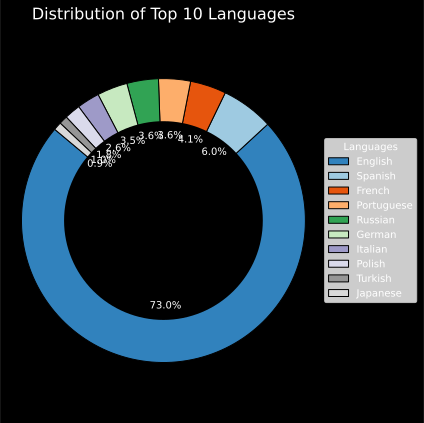

In [10]:
# Make a copy of the language column to avoid modifying the original dataset
language_series = dataset['language'].copy()

# Number of top languages to display
top_n = 10

# Get the most frequent languages
top_languages = language_series.value_counts().nlargest(top_n)

# Mapping of language codes to full names
language_name_mapping = {
    'en': 'English',
    'es': 'Spanish',
    'fr': 'French',
    'pt': 'Portuguese',
    'ru': 'Russian',
    'de': 'German',
    'it': 'Italian',
    'pl': 'Polish',
    'tr': 'Turkish',
    'ja': 'Japanese'
    # Add more mappings if needed
}

# Translate language codes to full names
full_language_names = [language_name_mapping.get(lang, lang) for lang in top_languages.index]

# Create a color palette
colors = plt.cm.tab20c(np.linspace(0, 1, top_n))

# Create the donut chart
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(
    top_languages,
    labels=None,  # Labels will go in the legend
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
    textprops={'fontsize': 10}
)

# Improve percentage label readability
for autotext in autotexts:
    autotext.set_color('white')

# Add a circle to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='black')  # Center circle for donut effect
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Title
plt.title(f'Distribution of Top {top_n} Languages', fontsize=16, color='white')

# Equal aspect ratio ensures the pie is drawn as a circle
plt.axis('equal')

# Apply dark mode
plt.gca().set_facecolor('black')
fig.patch.set_facecolor('black')

# Create the legend using full language names
legend = plt.legend(
    patches,
    full_language_names,
    title="Languages",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=10
)

# Style legend for dark mode
plt.setp(legend.get_title(), color='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()


# Which artists have the most views?

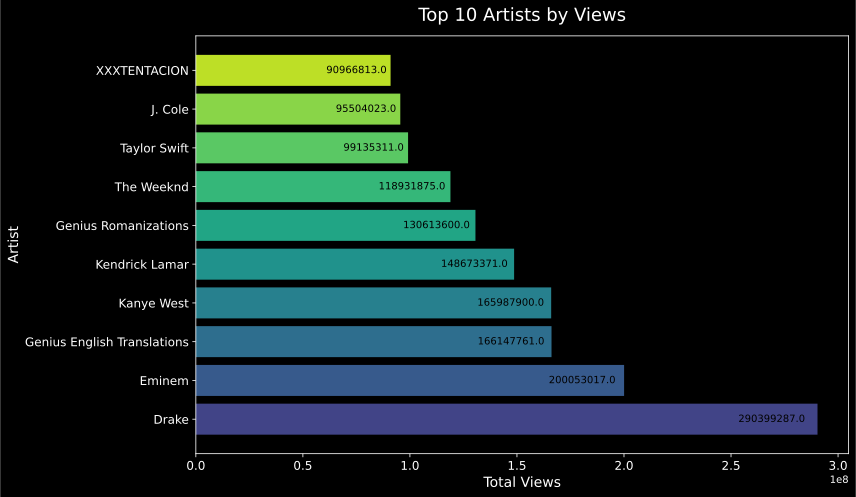

In [11]:
# Group by artist and sum views, get top 10
top_artists = dataset.groupby('artist')['views'].sum().nlargest(10).reset_index()

# Sort by views
top_artists = top_artists.sort_values(by='views', ascending=False)

# Map artist short names to full names
artist_name_mapping = {
    'Artist1': 'Artist One',
    'Artist2': 'Artist Two',
    'Artist3': 'Artist Three',
    # Add more mappings as needed
}
full_artist_names = [artist_name_mapping.get(artist, artist) for artist in top_artists['artist']]

# Prepare color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_artists)))

# Plot (fast, stylish, and clean)
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(full_artist_names, top_artists['views'], color=colors)

# Labels and titles
ax.set_title('Top 10 Artists by Views', fontsize=18, color='white', pad=15)
ax.set_xlabel('Total Views', fontsize=14, color='white')
ax.set_ylabel('Artist', fontsize=14, color='white')
ax.tick_params(colors='white', labelsize=12)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Add value labels inside the bars
for i, val in enumerate(top_artists['views']):
    ax.text(val * 0.98, i, f'{val:.1f}', color='black', va='center', ha='right', fontsize=10)

plt.tight_layout()
plt.show()

# Is there a connection between language and popularity?

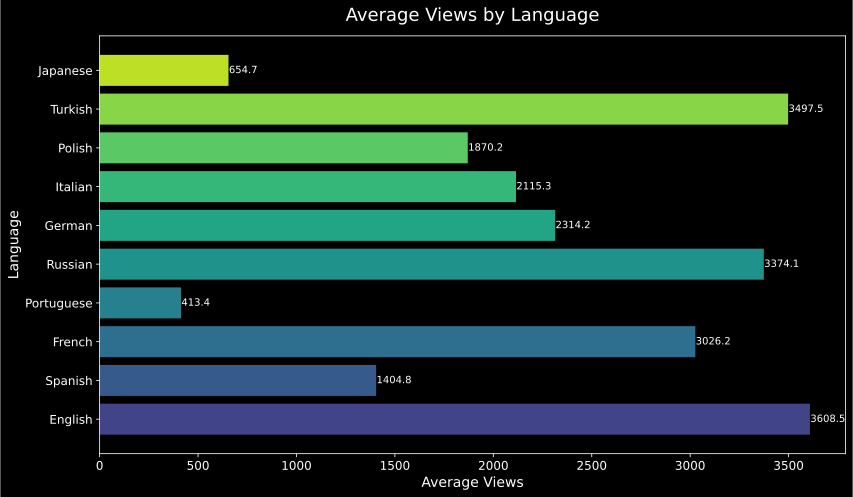

In [12]:
# Make a copy of the language column to avoid modifying the original dataset
language_series = dataset['language'].copy()

# Number of top languages to display
top_n = 10

# Get the most frequent languages (by language code)
top_languages = language_series.value_counts().nlargest(top_n)

# Filter dataset to include only rows with top languages
filtered_dataset = dataset[dataset['language'].isin(top_languages.index)]

# Calculate average views per language
language_views = filtered_dataset.groupby('language')['views'].mean().loc[top_languages.index]

# Mapping of language codes to full names
language_name_mapping = {
    'en': 'English',
    'es': 'Spanish',
    'fr': 'French',
    'pt': 'Portuguese',
    'ru': 'Russian',
    'de': 'German',
    'it': 'Italian',
    'pl': 'Polish',
    'tr': 'Turkish',
    'ja': 'Japanese'
}

# Translate language codes to full names
full_language_names = [language_name_mapping.get(lang, lang) for lang in top_languages.index]

# Prepare color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(language_views)))

# Plot
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(full_language_names, language_views.values, color=colors)

# Labels and titles
ax.set_title('Average Views by Language', fontsize=18, color='white', pad=15)
ax.set_xlabel('Average Views', fontsize=14, color='white')
ax.set_ylabel('Language', fontsize=14, color='white')
ax.tick_params(colors='white', labelsize=12)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Add value labels
for i, val in enumerate(language_views.values):
    ax.text(val + 2, i, f'{val:.1f}', color='white', va='center', fontsize=10)

plt.tight_layout()
plt.show()


# Analysis of the lyrics

In [13]:
# Count stats
num_songs = len(dataset)
num_artists = dataset['artist'].nunique()
num_languages = dataset['language'].nunique()
num_genres = dataset['tag'].nunique()
unique_genres = dataset['tag'].unique()

# Print formatted summary
print("=" * 40)
print("🎵 Dataset Summary")
print("=" * 40)
print(f"Total number of songs     : {num_songs}")
print(f"Unique artists            : {num_artists}")
print(f"Unique languages          : {num_languages}")
print(f"Unique genres             : {num_genres}")
print("\n🎧 Genres included:")
print(", ".join(sorted(unique_genres)))
print("=" * 40)


🎵 Dataset Summary
Total number of songs     : 5134856
Unique artists            : 641349
Unique languages          : 84
Unique genres             : 6

🎧 Genres included:
country, misc, pop, rap, rb, rock


Number of songs per genre:
tag
pop        2138587
rap        1724816
rock        793220
rb          196462
misc        181455
country     100316
Name: count, dtype: int64


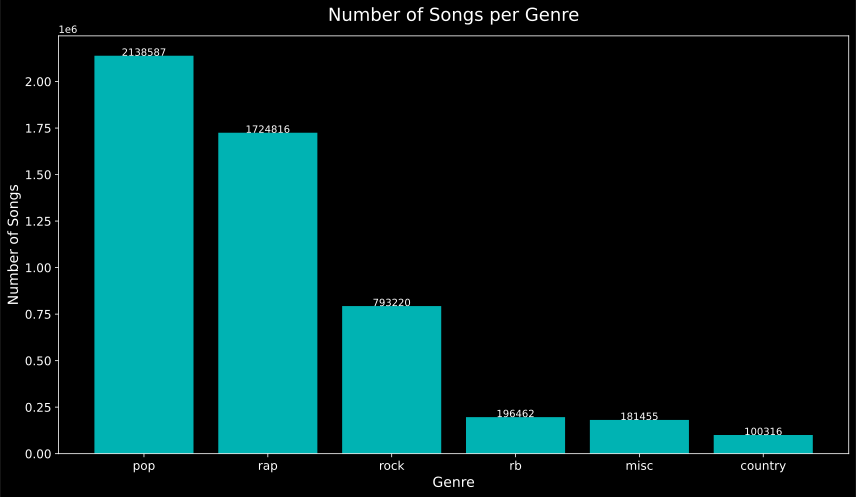

In [14]:
# How many songs are in each genre? # Count number of songs per genre
genre_counts = dataset['tag'].value_counts()
# Print number of songs per genre
print("Number of songs per genre:")
print(genre_counts)
# Plot bar chart of number of songs per genre
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(genre_counts.index, genre_counts.values, color='cyan', alpha=0.7)
# Labels and titles
ax.set_title('Number of Songs per Genre', fontsize=18, color='white', pad=15)
ax.set_xlabel('Genre', fontsize=14, color='white')
ax.set_ylabel('Number of Songs', fontsize=14, color='white')
ax.tick_params(colors='white', labelsize=12)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
# Add value labels
for i, val in enumerate(genre_counts.values):
    ax.text(i, val + 2, str(val), color='white', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Problem jahre stimmen glaub nicht was sollen wir machen es gibt songs aus 1658 und 2100

# @ ivan TODO interaktive plot damit man sehen wie viele Songs in welchem jahr gestreamt wurden

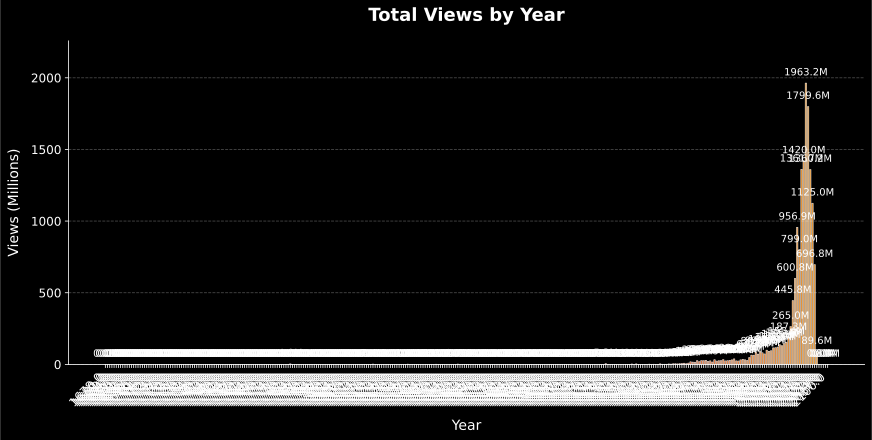

In [15]:
# Group by year and calculate total views
year_views = dataset.groupby('year')['views'].sum().reset_index()

# Ensure the 'year' column is treated as string for plotting
year_views['year'] = year_views['year'].astype(str)

# Sort by year for chronological order (or by views if you prefer)
year_views = year_views.sort_values(by='year')

# Calculate values in millions for better readability
year_views['views_millions'] = year_views['views'] / 1_000_000

# Create figure with constrained layout
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

# Color settings
cmap = plt.cm.plasma
colors = cmap(np.linspace(0.2, 0.8, len(year_views)))

# Bar plot with improved styling
bars = ax.bar(
    year_views['year'],
    year_views['views_millions'],
    color=colors,
    width=0.7,
    edgecolor='white',
    linewidth=0.5,
    alpha=0.9
)

# Title and labels with improved styling
ax.set_title('Total Views by Year', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14, labelpad=10)
ax.set_ylabel('Views (Millions)', fontsize=14, labelpad=10)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(year_views)))
ax.set_xticklabels(year_views['year'], rotation=45, ha='right')

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + max(year_views['views_millions']) * 0.02,
        f'{height:.1f}M',
        ha='center', 
        va='bottom',
        fontsize=10,
        color='white'
    )

# Remove spines for cleaner look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Add some margin at the top
ax.set_ylim(top=max(year_views['views_millions']) * 1.15)

plt.show()

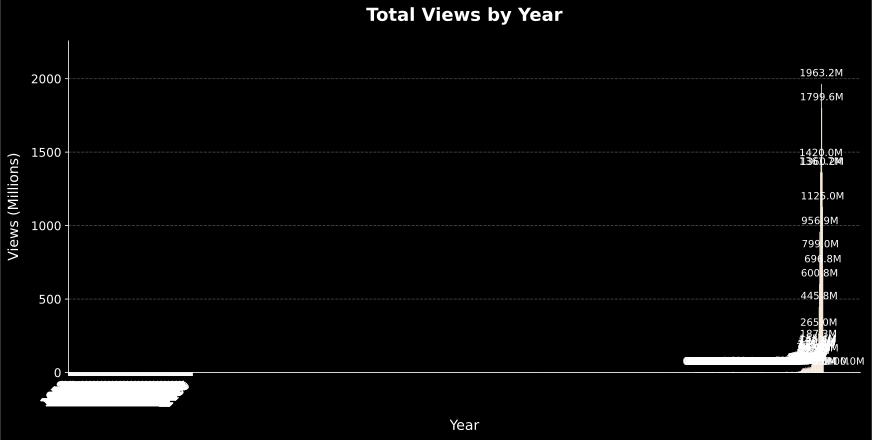

In [16]:
# Group by year and calculate total views
year_views = dataset.groupby('year')['views'].sum().reset_index()

# Ensure the 'year' column is treated as integer for plotting
year_views['year'] = year_views['year'].astype(int)

# Sort by year for chronological order
year_views = year_views.sort_values(by='year')

# Calculate values in millions for better readability
year_views['views_millions'] = year_views['views'] / 1_000_000

# Create figure with constrained layout
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)

# Color settings
cmap = plt.cm.plasma
colors = cmap(np.linspace(0.2, 0.8, len(year_views)))

# Bar plot with improved styling
bars = ax.bar(
    year_views['year'],
    year_views['views_millions'],
    color=colors,
    width=0.7,
    edgecolor='white',
    linewidth=0.5,
    alpha=0.9
)

# Title and labels with improved styling
ax.set_title('Total Views by Year', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14, labelpad=10)
ax.set_ylabel('Views (Millions)', fontsize=14, labelpad=10)

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(year_views)))
ax.set_xticklabels(year_views['year'], rotation=45, ha='right')

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2., 
        height + max(year_views['views_millions']) * 0.02,
        f'{height:.1f}M',
        ha='center', 
        va='bottom',
        fontsize=10,
        color='white'
    )

# Remove spines for cleaner look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Add some margin at the top
ax.set_ylim(top=max(year_views['views_millions']) * 1.15)

plt.show()


/var/folders/0r/39hlpxw13456w7klfqzkk0dh0000gn/T/ipykernel_87194/2451505363.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/0r/39hlpxw13456w7klfqzkk0dh0000gn/T/ipykernel_87194/2451505363.py:42: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/lucaschambeck/anaconda3/envs/PM4_ENV/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


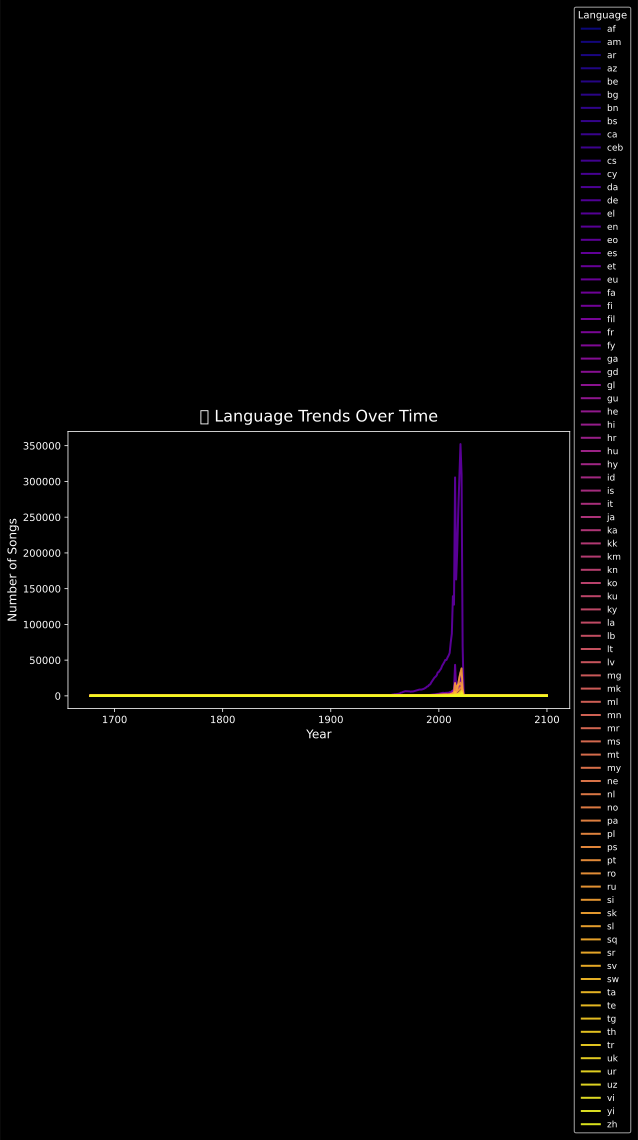

In [17]:
# Group by year and language, count songs
language_trends = dataset.groupby(['year', 'language']).size().reset_index(name='song_count')

# Ensure no duplicates by summing the counts for each year-language pair
language_trends = language_trends.groupby(['year', 'language'])['song_count'].sum().reset_index()

# Pivot the DataFrame: years as rows, languages as columns
language_trends_pivot = language_trends.pivot(index='year', columns='language', values='song_count').fillna(0)

# Sort by year for correct time order
language_trends_pivot = language_trends_pivot.sort_index()

# Dark mode plot setup
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(9, 5))  # smaller and neater

# Plot the line chart
language_trends_pivot.plot(
    kind='line',
    ax=ax,
    linewidth=2,
    alpha=0.9,
    colormap='plasma'  # optional: you can try 'tab10', 'Set2', etc.
)

# Title & labels
ax.set_title('📈 Language Trends Over Time', fontsize=16, color='white', pad=10)
ax.set_xlabel('Year', fontsize=12, color='white')
ax.set_ylabel('Number of Songs', fontsize=12, color='white')

# Axis formatting
ax.tick_params(colors='white', labelsize=10)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Optional: add legend outside
legend = ax.legend(title='Language', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.setp(legend.get_title(), color='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

# Get top 10 genres (tags)
top_tags = dataset['tag'].value_counts().nlargest(10).index

# Filter dataset for top tags
filtered_data = dataset[dataset['tag'].isin(top_tags)]

# Preprocess lyrics: lowercase + remove punctuation
filtered_data['clean_lyrics'] = (
    filtered_data['lyrics']
    .str.lower()
    .str.replace(r'[^a-z\s]', '', regex=True)
)

# Split words and explode for counting
filtered_data['word_list'] = filtered_data['clean_lyrics'].str.split()
exploded = filtered_data.explode('word_list')

# Remove stopwords (optional, if available)
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# exploded = exploded[~exploded['word_list'].isin(stop_words)]

# Count word frequency per tag
word_counts = (
    exploded.groupby('tag')['word_list']
    .apply(lambda words: Counter(words).most_common(10))
)

# Prepare data for plotting
words, counts, genres = [], [], []
for genre, word_list in word_counts.items():
    for word, count in word_list:
        words.append(word)
        counts.append(count)
        genres.append(genre)

# Set up colors
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(words)))

# Plot
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(words, counts, color=colors)

# Add labels & style
ax.set_title('🔤 Most Common Words by Genre (Top 10 Tags)', fontsize=16, color='white', pad=10)
ax.set_xlabel('Word Count', fontsize=12, color='white')
ax.set_ylabel('Words', fontsize=12, color='white')
ax.tick_params(colors='white', labelsize=10)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Value labels on the bars
for i, val in enumerate(counts):
    ax.text(val + 2, i, str(val), color='white', va='center', fontsize=9)

plt.tight_layout()
plt.show()


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107531e20>>
Traceback (most recent call last):
  File "/Users/lucaschambeck/anaconda3/envs/PM4_ENV/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# Get top 10 artists
top_artists = dataset['artist'].value_counts().nlargest(10).index

# Filter dataset for those artists
filtered_data = dataset[dataset['artist'].isin(top_artists)]

# Preprocess lyrics: lowercase + clean up punctuation
filtered_data['clean_lyrics'] = (
    filtered_data['lyrics']
    .str.lower()
    .str.replace(r'[^a-z\s]', '', regex=True)
)

# Split words and explode into rows
filtered_data['word_list'] = filtered_data['clean_lyrics'].str.split()
exploded = filtered_data.explode('word_list')

# Optional: remove stopwords here if needed
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# exploded = exploded[~exploded['word_list'].isin(stop_words)]

# Count top words per artist
word_counts = (
    exploded.groupby('artist')['word_list']
    .apply(lambda words: Counter(words).most_common(10))
)

# Prepare data for bar plot
words, counts, artists = [], [], []
for artist, word_list in word_counts.items():
    for word, count in word_list:
        words.append(word)
        counts.append(count)
        artists.append(artist)

# Set up color palette
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(words)))

# Plot setup
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(words, counts, color=colors)

# Titles & labels
ax.set_title('🎤 Most Common Words by Artist (Top 10)', fontsize=16, color='white', pad=10)
ax.set_xlabel('Word Count', fontsize=12, color='white')
ax.set_ylabel('Words', fontsize=12, color='white')
ax.tick_params(colors='white', labelsize=10)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Add word count labels
for i, val in enumerate(counts):
    ax.text(val + 2, i, str(val), color='white', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Get top 10 tags (genres)
top_tags = dataset['tags'].value_counts().nlargest(10).index

# Filter dataset for those tags
filtered_data = dataset[dataset['tags'].isin(top_tags)]

# Preprocess lyrics: lowercase + clean up punctuation
filtered_data['clean_lyrics'] = (
    filtered_data['lyrics']
    .str.lower()
    .str.replace(r'[^a-z\s]', '', regex=True)
)

# Split into word list and explode to one word per row
filtered_data['word_list'] = filtered_data['clean_lyrics'].str.split()
exploded = filtered_data.explode('word_list')

# Count top words per tag
word_counts = (
    exploded.groupby('tags')['word_list']
    .apply(lambda words: Counter(words).most_common(10))
)

# Prepare data for plotting
words, counts, tag_labels = [], [], []
for tag, word_list in word_counts.items():
    for word, count in word_list:
        words.append(word)
        counts.append(count)
        tag_labels.append(tag)

# Set up color palette
colors = plt.cm.cividis(np.linspace(0.3, 0.9, len(words)))

# Plot setup
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(words, counts, color=colors)

# Titles & labels
ax.set_title('🎧 Most Common Words by Genre (Top 10 Tags)', fontsize=16, color='white', pad=10)
ax.set_xlabel('Word Count', fontsize=12, color='white')
ax.set_ylabel('Words', fontsize=12, color='white')
ax.tick_params(colors='white', labelsize=10)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Add value labels
for i, val in enumerate(counts):
    ax.text(val + 2, i, str(val), color='white', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Which genres perform best? # Group by genre and calculate mean views
genre_views = dataset.groupby('genre')['views'].mean().reset_index()
# Sort by views
genre_views = genre_views.sort_values(by='views', ascending=False)
# Map genre codes to full names
genre_name_mapping = {
    'Pop': 'Pop',
    'Rock': 'Rock',
    'Hip-Hop': 'Hip-Hop',
    'R&B': 'R&B',
    'Country': 'Country',
    'Jazz': 'Jazz',
    'Classical': 'Classical',
    # Add more mappings if needed
}
full_genre_names = [genre_name_mapping.get(genre, genre) for genre in genre_views['genre']]
# Prepare color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(genre_views)))
# Plot (fast, stylish, and clean)
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(full_genre_names, genre_views['views'], color=colors)
# Labels and titles
ax.set_title('Average Views by Genre', fontsize=18, color='white', pad=15)
ax.set_xlabel('Average Views', fontsize=14, color='white')
ax.set_ylabel('Genre', fontsize=14, color='white')
ax.tick_params(colors='white', labelsize=12)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
# Add value labels
for i, val in enumerate(genre_views['views']):
    ax.text(val + 2, i, f'{val:.1f}', color='white', va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
# Create a copy of relevant columns to avoid modifying the original dataset
data_copy = dataset[['language', 'lyrics']].copy()

# Add lyrics length column without changing original dataset
data_copy['lyrics_length'] = data_copy['lyrics'].apply(lambda x: len(str(x).split()))

# Get the top 10 most common languages
top_n = 10
top_languages = data_copy['language'].value_counts().nlargest(top_n).index

# Filter to top 10 languages
filtered_data = data_copy[data_copy['language'].isin(top_languages)]

# Map language codes to full names
language_name_mapping = {
    'en': 'English',
    'es': 'Spanish',
    'fr': 'French',
    'pt': 'Portuguese',
    'ru': 'Russian',
    'de': 'German',
    'it': 'Italian',
    'pl': 'Polish',
    'tr': 'Turkish',
    'ja': 'Japanese'
    # Add more if needed
}
filtered_data['language_full'] = filtered_data['language'].map(language_name_mapping).fillna(filtered_data['language'])

# Calculate average lyrics length for each language
avg_lyrics_length = filtered_data.groupby('language_full')['lyrics_length'].mean().sort_values(ascending=False)

# Plotting
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12, 7))

# Color palette
colors = plt.cm.viridis(np.linspace(0.2, 0.9, top_n))

# Create horizontal bar plot
avg_lyrics_length.plot(kind='barh', color=colors, ax=ax)

# Styling
ax.set_title('Average Lyrics Length by Language (Top 10)', fontsize=18, color='white', pad=15)
ax.set_xlabel('Average Number of Words', fontsize=14, color='white')
ax.set_ylabel('Language', fontsize=14, color='white')
ax.tick_params(colors='white', labelsize=12)
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

# Add text labels to bars
for i, (lang, val) in enumerate(avg_lyrics_length.items()):
    ax.text(val + 2, i, f'{val:.1f}', color='white', va='center', fontsize=10)

plt.tight_layout()
plt.show()
